In [2]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from sklearn.metrics import *
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from itertools import chain
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'seaborn'

: 

In [39]:
# Индекс выпуска по базовым видам экономической деятельности (BBR_EA_M_I)
path = './17_var.csv'
df = pd.read_csv(path, header=0, delimiter=';')
df = df.iloc[:, :2]
df = df.drop(index=0)
df.head(3)

,T,BBR_EA_M_I
1,2003 1,100
2,2,98.6
3,3,109.3


# Предварительный анализ временных рядов

In [40]:
years = [np.ones(12)*i for i in range(2003, 2003+math.floor(len(df)/12))] + [np.ones(4)*2016]
years = np.hstack(years)
df['year'] = years
df['year'] = df['year'].astype(int)
df['month'] = [int(i) if len(i) < 3 else int(i.split(" ")[-1]) for i in df["T"]]
df['month'] = df['month'].astype(int)
df['BBR_EA_M_I'] = df['BBR_EA_M_I'].astype(float)
df.drop('T', axis=1, inplace=True)
df.head(3)

,BBR_EA_M_I,year,month
1,100.0,2003,1
2,98.6,2003,2
3,109.3,2003,3


In [41]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str), format='%Y-%m')
df.head(3)

,BBR_EA_M_I,year,month,date
1,100.0,2003,1,2003-01-01
2,98.6,2003,2,2003-02-01
3,109.3,2003,3,2003-03-01


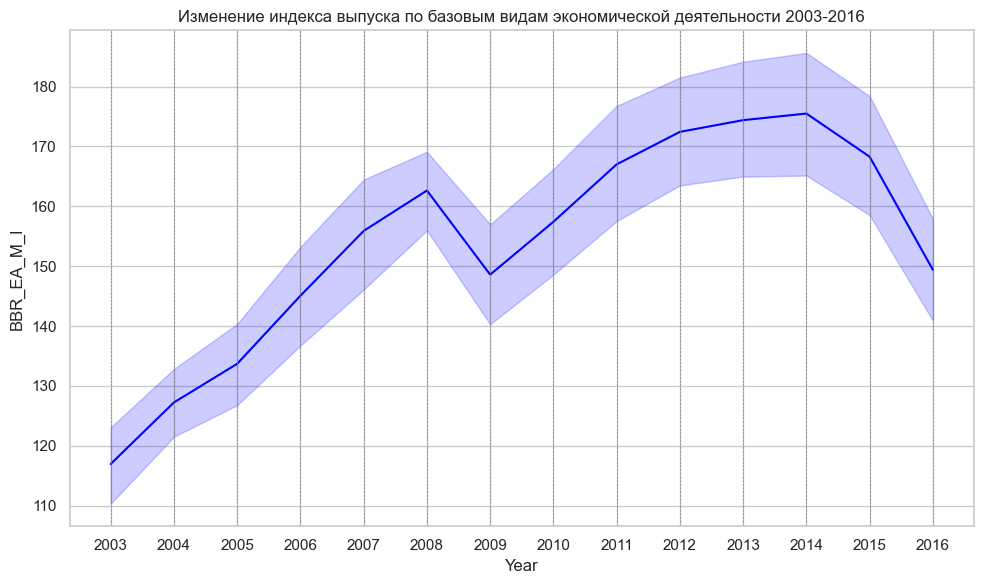

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Устанавливаем стиль seaborn
sns.set(style="whitegrid")

# Создаем график
plt.figure(figsize=(10, 6))

# Строим график
sns.lineplot(data=df, x='year', y='BBR_EA_M_I', color='blue')

# Добавляем вертикальные линии для обозначения годов
for year in df['year'].unique():
    plt.axvline(x=year, color='grey', linestyle='--', linewidth=0.5)

# Настройки для графика
plt.xlabel('Year')
plt.ylabel('BBR_EA_M_I')
plt.title('Изменение индекса выпуска по базовым видам экономической деятельности 2003-2016')
plt.xticks(list(df['year'].unique()))

plt.tight_layout()
plt.show()


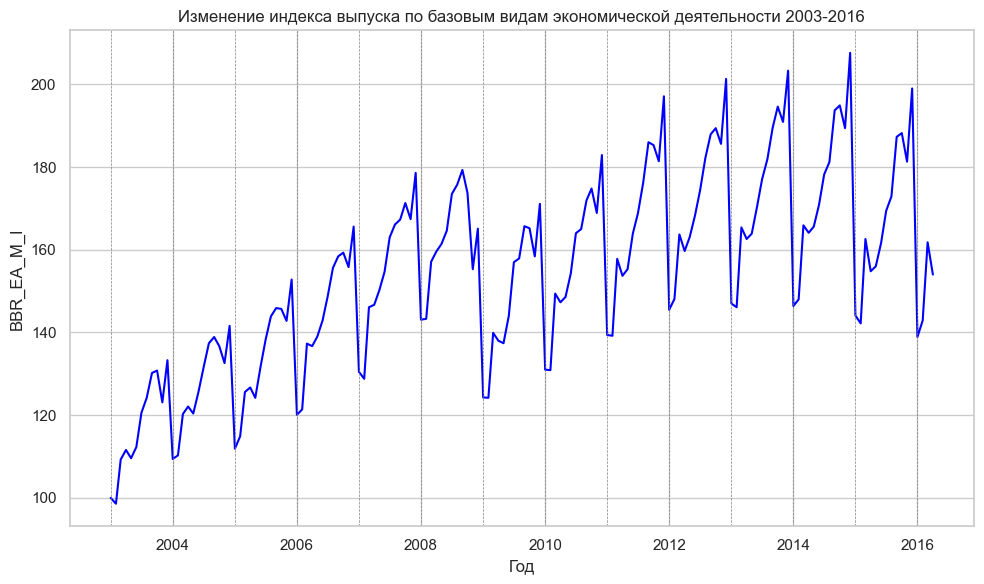

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Устанавливаем стиль seaborn
sns.set(style="whitegrid")

# Создаем график
plt.figure(figsize=(10, 6))

# Строим график
sns.lineplot(data=df, x='date', y='BBR_EA_M_I', color='blue')

# Добавляем вертикальные линии для обозначения годов
for year in df['year'].unique():
    plt.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=0.5)

# Настройки для графика
plt.xlabel('Год')
plt.ylabel('BBR_EA_M_I')
plt.title('Изменение индекса выпуска по базовым видам экономической деятельности 2003-2016')

plt.tight_layout()
plt.show()


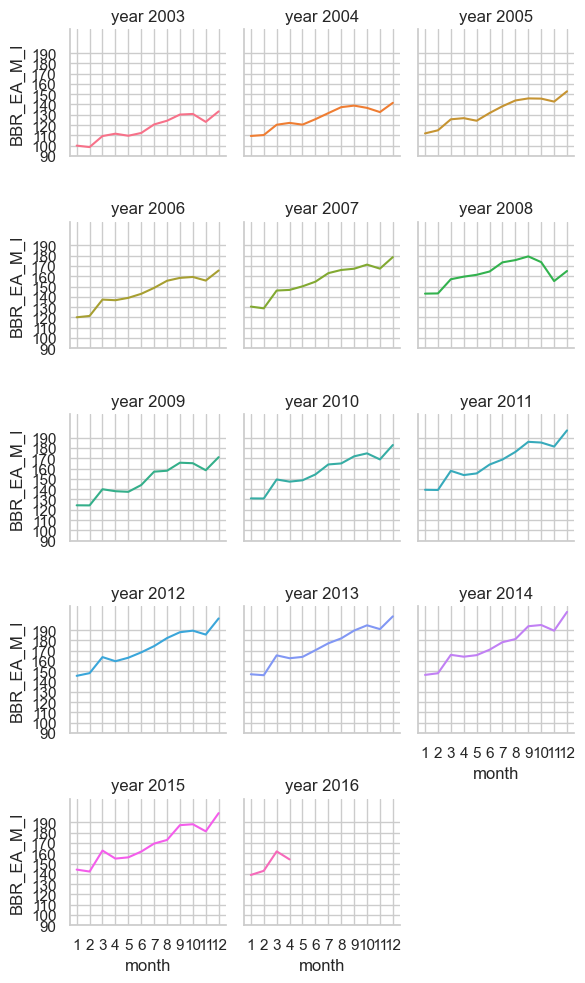

In [44]:
# Создание графиков с разделением по годам
g = sns.FacetGrid(df, col="year", hue="year", col_wrap=3, height=2)
g.map(sns.lineplot, "month", "BBR_EA_M_I")

# Настройка внешнего вида графиков
g.set_axis_labels("month", "BBR_EA_M_I")
g.set_titles("year {col_name}")
g.set(xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticks=range(90, 200, 10))

plt.show()

<Axes: >

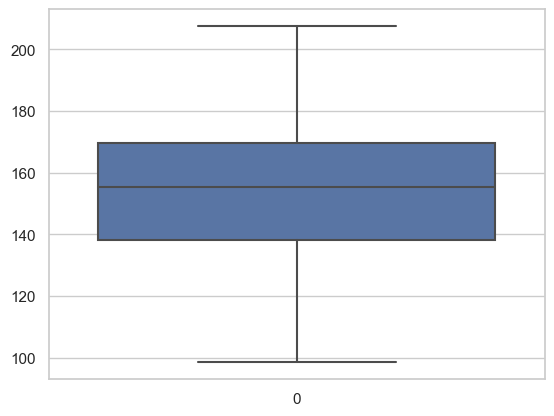

In [45]:
sns.boxplot(df['BBR_EA_M_I'].values)

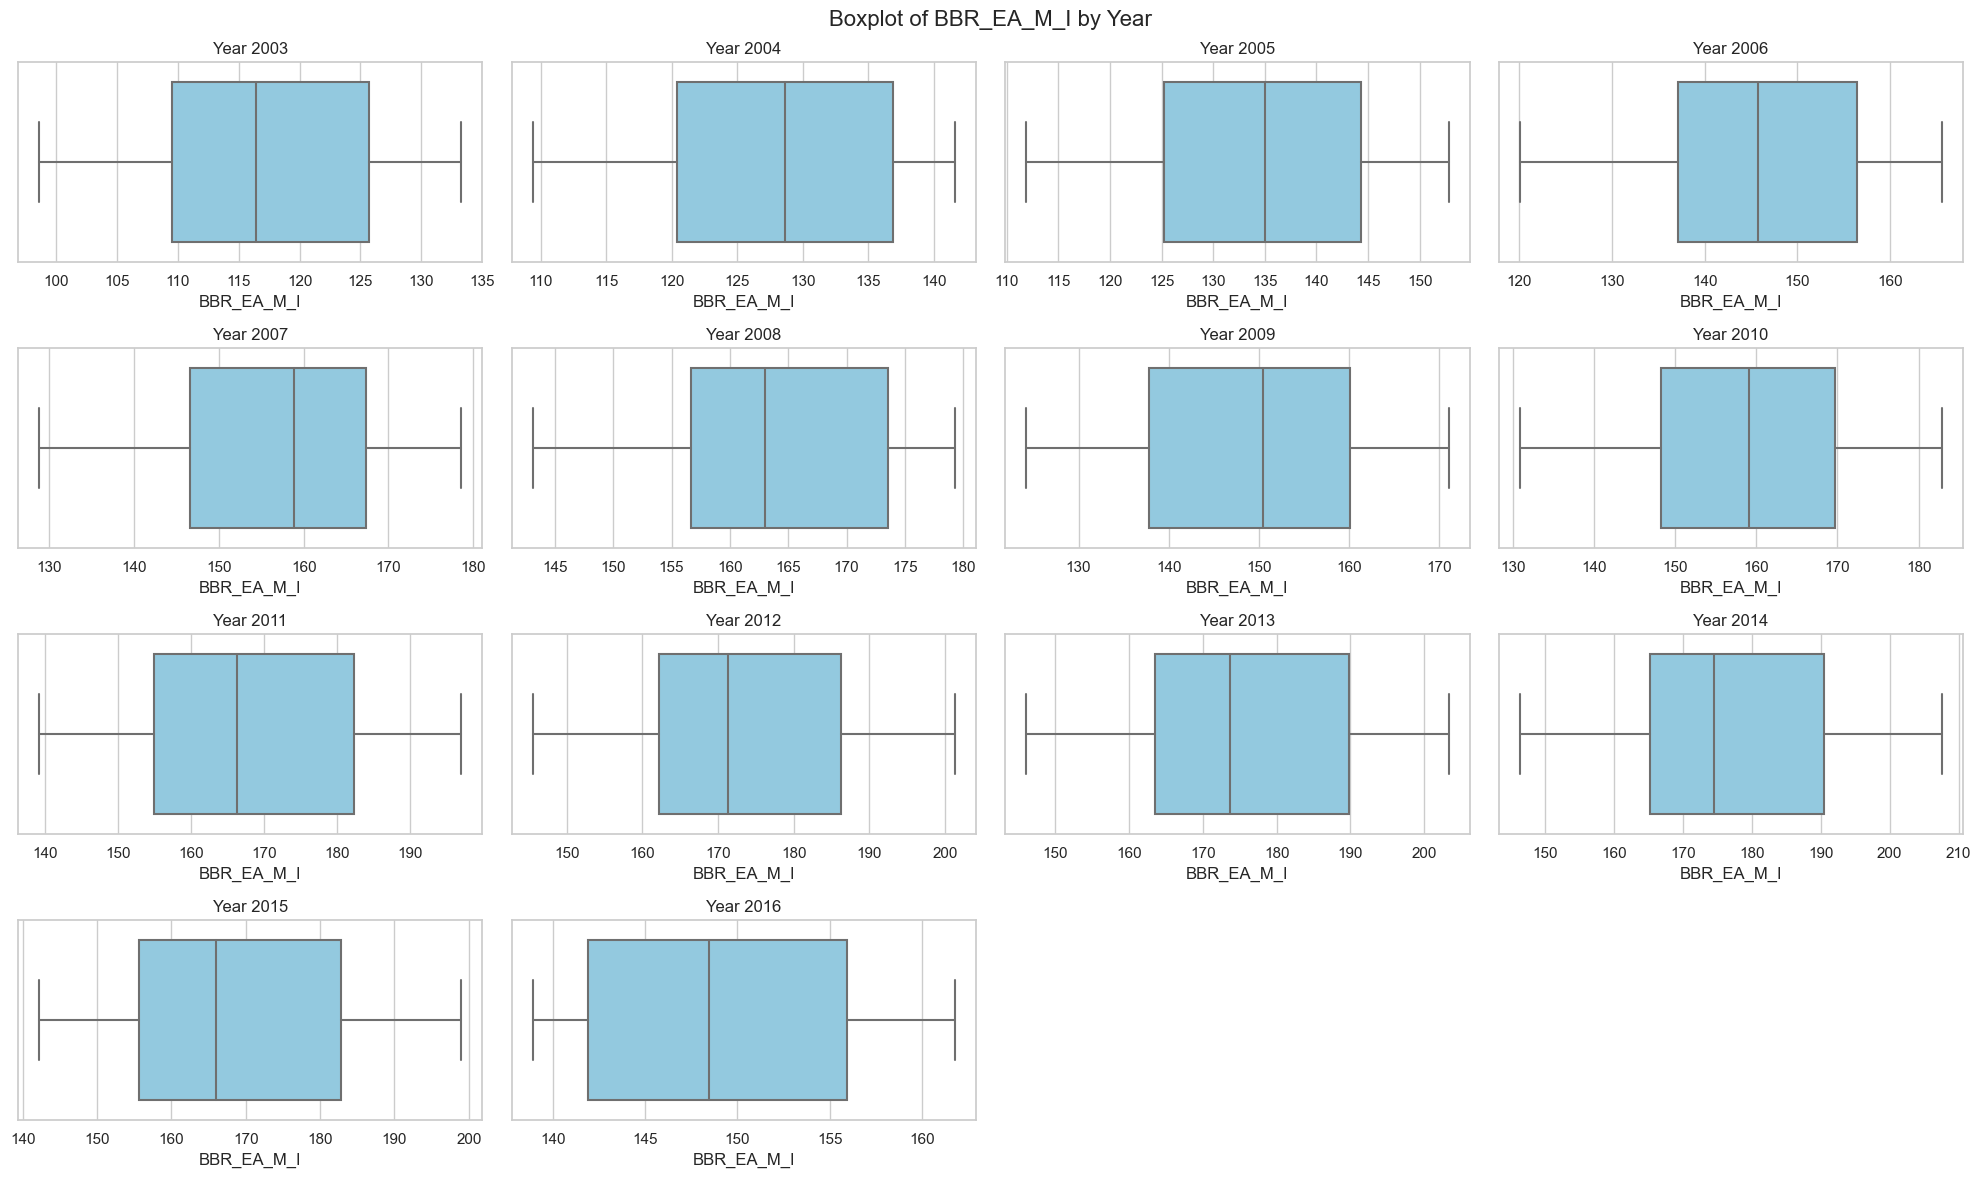

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 12))

for i, year in enumerate(df['year'].unique()):
    temp_df = df[df['year'] == year]
    ax = axs[i // 4, i % 4]  # Определение текущего положения подграфика в сетке
    sns.boxplot(x='BBR_EA_M_I', data=temp_df, ax=ax, color='skyblue')
    ax.set_title(f'Year {year}')  # Установка заголовка для каждой диаграммы

# Удаляем пустые подграфики
for i in range(len(df['year'].unique()), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])
    
# Устанавливаем общий заголовок для всех графиков
fig.suptitle('Boxplot of BBR_EA_M_I by Year', fontsize=16)

plt.tight_layout()
plt.show()


Отдельно построим изменение целевой переменной в периоде 2008-2009

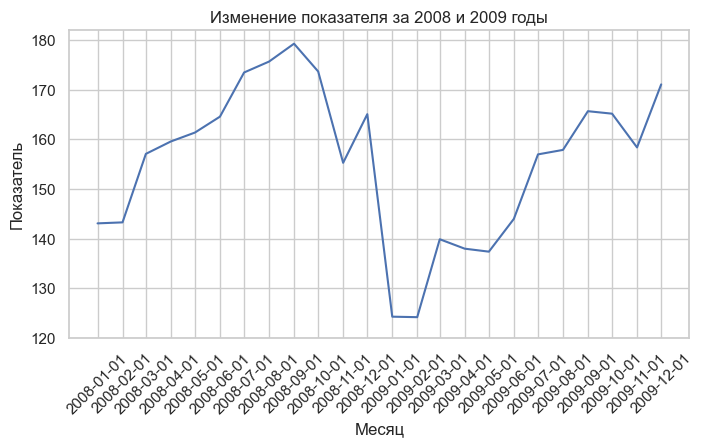

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Фильтрация данных по нужным годам
df_2008_2009 = df[df['year'].isin([2008, 2009])]

# Создание графика
plt.figure(figsize=(8, 4))
g = sns.lineplot(x='date', y='BBR_EA_M_I', data=df_2008_2009)
g.set(xticks=df_2008_2009['date'], yticks=range(120, 190, 10))
plt.title('Изменение показателя за 2008 и 2009 годы')
plt.xlabel('Месяц')
plt.ylabel('Показатель')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


По графику видно, что возрастающий тренд 2008 года обрывается на 9 месяце (с 10 уже начинается падение). Далее возрастающий тренд начинается только на 1 месяце 2009 года. Получается требует отдельной проверки период с октября по декабрь 2008 года (10, 11, 12 месяцы, весь 4 квартал).  

# Процедура выявления аномальных наблюдений

## На основе распределения Стьюдента

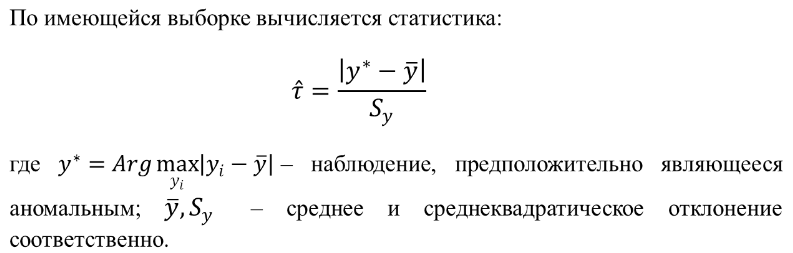

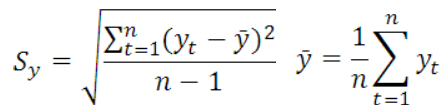

In [48]:
y = df['BBR_EA_M_I'].values
n = len(y)
S_y = np.sqrt(np.sum((y - np.mean(y))**2) / (n-1))
# у нас 3 значения (10, 11, 12 месяцы 2008 года под вопросом)
y_anomalys = [df[(df['year']==2008) & (df['month']==month)]['BBR_EA_M_I'].values[0] for month in [10, 11, 12]]
tau = []
for y_anomaly in y_anomalys:
    tau.append(np.abs(y_anomaly - np.mean(y))/S_y)

tau

[0.8344451000676731, 0.05028831553012454, 0.4679370377294709]

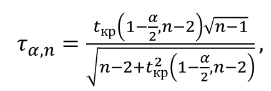

In [49]:
# посчитаем критическое значение tau(0.05, n)
alpha1 = 0.05
ttable1 = t.ppf(1-alpha1/2, n-2) # t табличное
tau_table1 = (ttable1 * np.sqrt(n-1))/(np.sqrt(n-2+ttable1**2))

alpha2 = 0.001
ttable2 = t.ppf(1-alpha2/2, n-2) 
tau_table2 = (ttable2 * np.sqrt(n-1))/(np.sqrt(n-2+ttable2**2))

tau_table1, tau_table2

(1.9573169526285275, 3.2501061268784373)

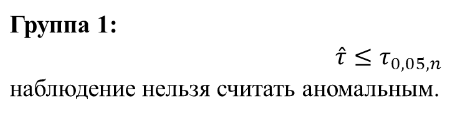

In [50]:
tau[0] <= tau_table1, tau[1] <= tau_table1, tau[2] <= tau_table1

(True, True, True)

Метод на основе распределения Стьюдента показал, что ни одно из значений из выбранных нами месяцев не является аномальным.

## Метод Ирвина

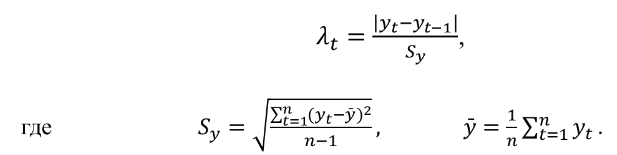

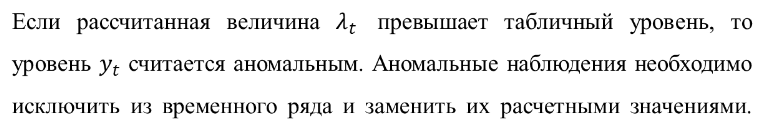

In [51]:
y_anomalys = [df[(df['year']==2008) & (df['month']==month)]['BBR_EA_M_I'].values[0] for month in [10, 11, 12]]
S_y = np.sqrt(np.sum((y - np.mean(y))**2) / (n-1))
# предыдущие игреки для каждого аномального
y_previous = [df.loc[df[(df['year']==2008) & (df['month']==10)].index[0]-1]['BBR_EA_M_I'] for month in [10, 11, 12]]

lmbd_t = []
for i in range(len(y_anomalys)):
    lmbd_t.append(np.abs(y_anomalys[i] - y_previous[i])/S_y)
lmbd_t

[0.23865641268534213, 1.0228131972228907, 0.6051644750235444]

In [52]:
lmbd_crit = 0.95 # по таблице
# второй по счету элемент (11 месяц 2008) превышает табличный уровень, поэтому его мы удалим и заменим средним значением
lmbd_t[0]>lmbd_crit, lmbd_t[1]>lmbd_crit, lmbd_t[2]>lmbd_crit

(False, True, False)

In [53]:
# замена аномального значения на среднее
index_temp = df[(df['year']==2008) & (df['month']==11)].index
df.loc[index_temp]['BBR_EA_M_I'] = (df.loc[index_temp-1]['BBR_EA_M_I'] + df.loc[index_temp+1]['BBR_EA_M_I'])/2

# Проверка на наличие тренда в данных

воспользуемся критерием серий, основанных на медиане

In [221]:
y = df['BBR_EA_M_I'].values
y = sorted(y)

median = np.median(y)
ls = ['+' if i > median else '-' for i in y]

# Подсчет числа серий
num_series = 0
for i in range(len(ls)):
    if i == 0 or ls[i] != ls[i - 1]:
        num_series += 1

# Вычисление максимальной протяженности серии
max_length = 0
current_length = 0
for sign in ls:
    if sign == ls[i]:
        current_length += 1
    else:
        max_length = max(max_length, current_length)
        current_length = 1

# Учитываем последнюю серию
max_length = max(max_length, current_length)

print("Число серий:", num_series)
print("Максимальная протяженность серии:", max_length)

Число серий: 2
Максимальная протяженность серии: 81


In [223]:
max_length < 3.3 * np.log(len(y)+1)

False

In [224]:
num_series > (1/2*(n+1 - 1.96*np.sqrt(len(y)-1)))

False

гипотеза о отсутствии систематической составляющей отвергается. Значит тренд есть. 

# 1. Выбор кривой роста

## Предварительное сглаживание ряда

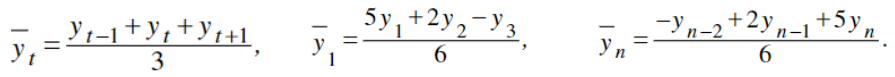

In [54]:
m = 3
y = df['BBR_EA_M_I'].values
n = len(df)
y_smoothing = []
y_0 = (5*y[0] + 2*y[1] - y[2])/6
y_n = (-y[n-3] + 2*y[n-2]+5*y[n-1])/6
y_smoothing.append(y_0)

for i in range(1, len(y)-1):
    y_temp = (y[i-1]+y[i]+y[i+1])/3
    y_smoothing.append(y_temp)

y_smoothing.append(y_n)

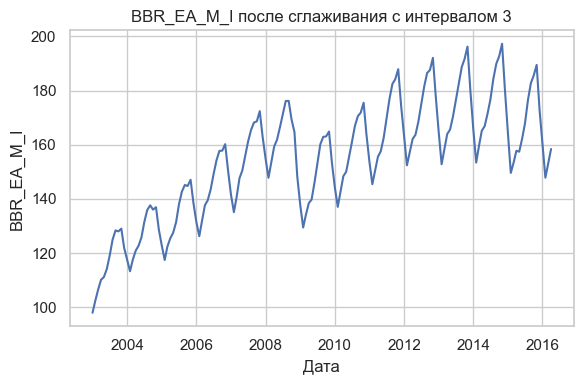

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# списки с данными
dates = df['date']  
numbers = y_smoothing 

data = {'Date': dates, 'Number': numbers}
df_temp = pd.DataFrame(data)

sns.set(style="whitegrid")

# создаем график
plt.figure(figsize=(6, 4))
sns.lineplot(x='Date', y='Number', data=df_temp)

# настройки для графика
plt.title('BBR_EA_M_I после сглаживания с интервалом 3')
plt.xlabel('Дата')
plt.ylabel('BBR_EA_M_I')

plt.tight_layout()
plt.show()


## Метод характеристик прироста

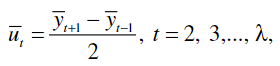  
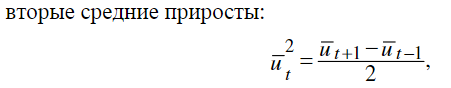

In [88]:
window_size = 3
y = df['BBR_EA_M_I'].values
y_smoothing = np.convolve(y, np.ones(window_size)/window_size, mode='same')

In [89]:
# первые средние приросты
u_t = [(y_smoothing[i+1]+y_smoothing[i-1])/2 for i in range(1, len(y_smoothing)-1)]
u_t_2 = [(u_t[i+1]+u_t[i-1])/2 for i in range(1, len(u_t)-1)]

Посчитаем производные величины  
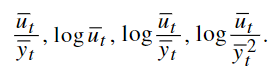

In [90]:
ut_y_fraq = [u_t[i-1]/y_smoothing[i] for i in range(1, len(y_smoothing)-1)]
log_u = np.log(u_t)
log_ut_y = np.log(ut_y_fraq)
log_ut_y2 = np.log([u_t[i-1]/y_smoothing[i]**2 for i in range(1, len(y_smoothing)-1)])

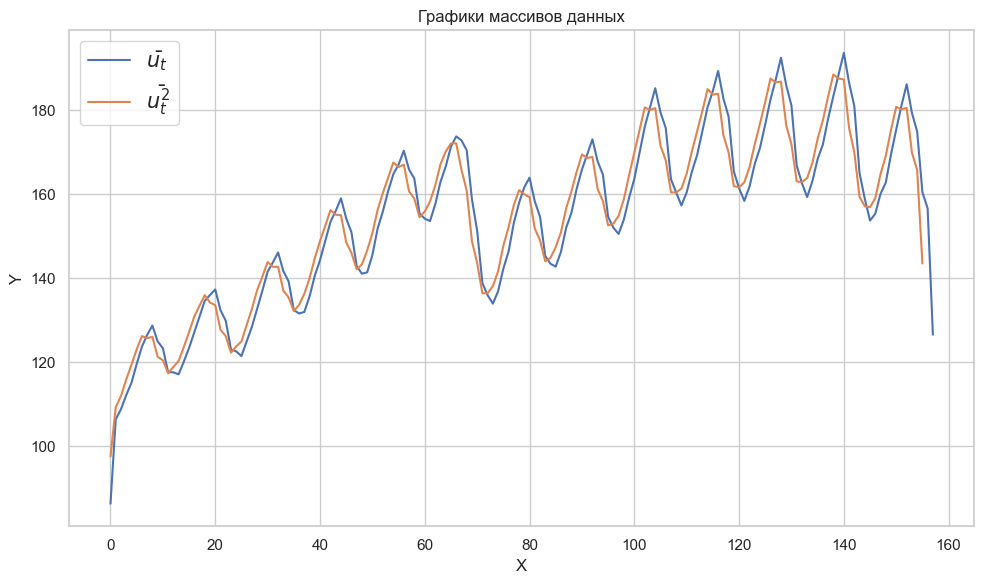

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))

arrays = [u_t, u_t_2]
for arr in arrays:
    ax.plot(arr)

ax.legend([r'$\bar{u_{t}}$', r'$\bar{u_{t}^{2}}$'], fontsize=15)  # подставьте соответствующие метки

ax.set_title('Графики массивов данных')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True)

plt.tight_layout()
plt.show()

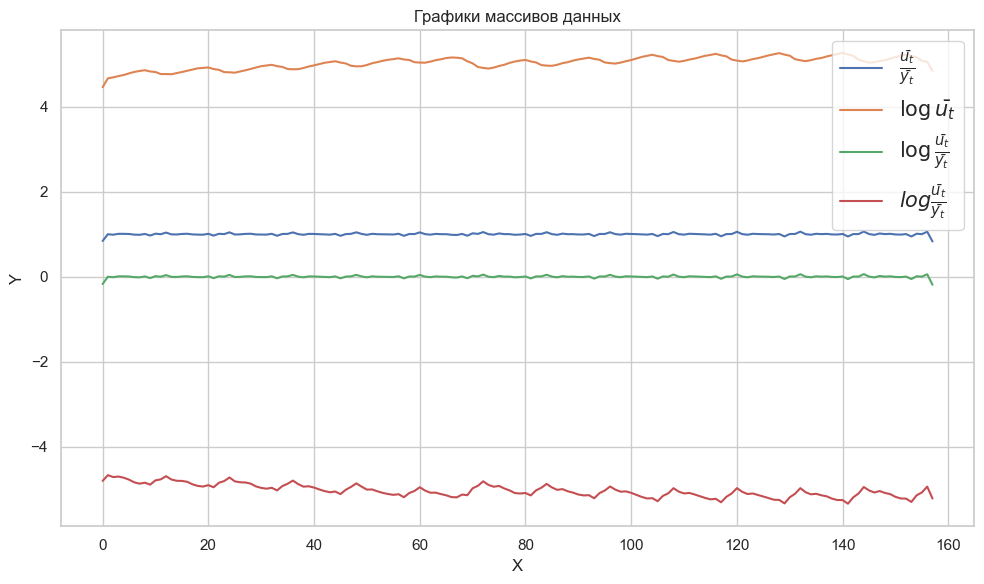

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))

arrays = [ut_y_fraq, log_u, log_ut_y, log_ut_y2]
for arr in arrays:
    ax.plot(arr)

ax.legend([r'$\frac{\bar{u_{t}}}{\bar{y_{t}}}$', r'$\log{\bar{u_{t}}}$', r'$\log{\frac{\bar{u_{t}}}{\bar{y_{t}}}}$',\
            r'$log{\frac{\bar{u_{t}}}{\bar{y_{t}}}}$', r'$log{\frac{\bar{u_{t}}}{\bar{y^2_{t}}}}$'], fontsize=15)  # подставьте соответствующие метки

ax.set_title('Графики массивов данных')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True)

plt.tight_layout()
plt.show()

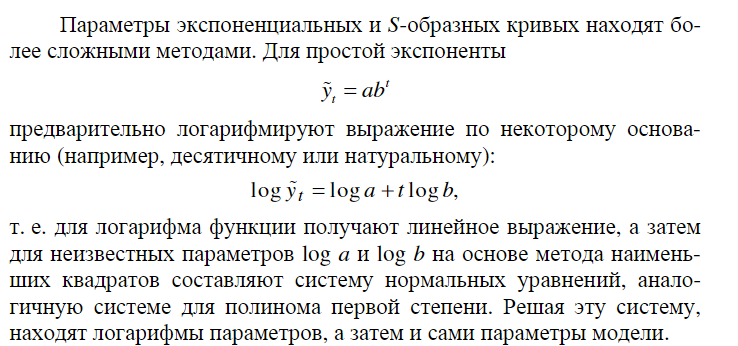

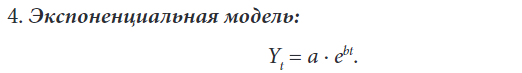

In [190]:
from scipy.optimize import minimize

y = df['BBR_EA_M_I'].values
t = df['date'].values
t = np.arange(0, len(t), 1)

# Определение функции для вычисления суммы квадратов разностей
def objective(params):
    a, b = params
    predicted_y = a * np.exp(b * t)
    return np.sum((y - predicted_y) ** 2)

# Начальное приближение для параметров a и b
initial_guess = [0, 0]  # Пример начального приближения

# Минимизация суммы квадратов разностей с помощью МНК
result = minimize(objective, initial_guess)
optimal_params = result.x

print("Оптимальные параметры a и b:", optimal_params)

Оптимальные параметры a и b: [1.28219545e+02 2.24925379e-03]


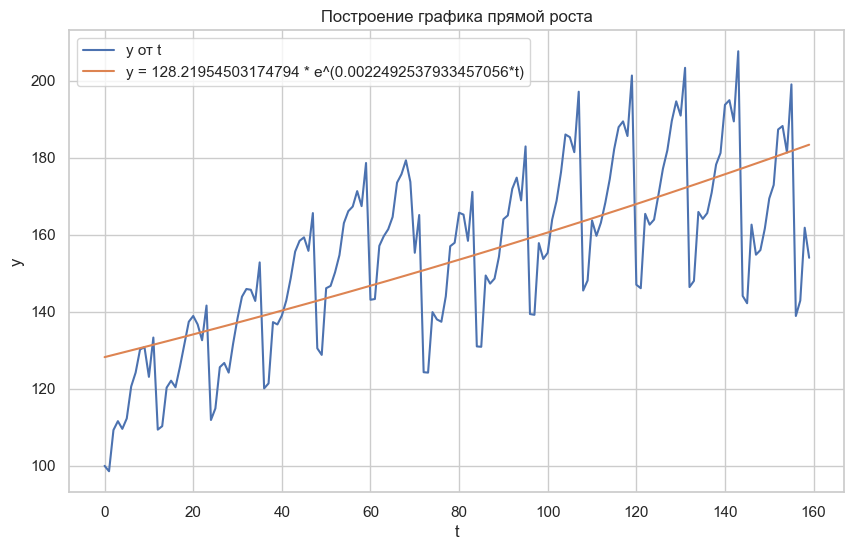

In [192]:
a, b = optimal_params
t = np.arange(0, len(df), 1)
y_func = a * np.exp(b * t)
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='y от t')
plt.plot(t, y_func, label=f'y = {a} * e^({b}*t)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Построение графика прямой роста')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
# сглаживание данных с произвольным размером окна
# window_size = 12
# smoothed_y = np.convolve(y, np.ones(window_size)/window_size, mode='same')


# 2. Провести прогнозирование с помощью кривой роста. Рассчитать точечный и интервальный прогноз на 4 периода вперед. 

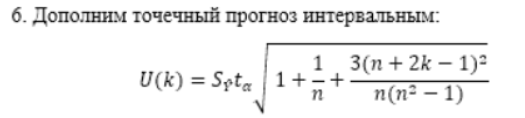

In [196]:
np.arange(len(df), len(df)+4,1)

array([160, 161, 162, 163])

In [205]:
from scipy.stats import t as t_test

a_optimal, b_optimal = optimal_params

# Прогнозирование на 4 периода вперед
future_t = np.arange(len(df), len(df)+4,1)  # Пример периодов для прогноза
t = np.arange(0, len(df), 1)
future_y_point_forecast = a * np.exp(b * future_t)

# Стандартное отклонение прогноза
residuals = y - (a * np.exp(b * t))
std_dev = np.sqrt(np.sum(residuals ** 2) / (len(t) - 2))

# Коэффициент для доверительного интервала
t_value = t_test.ppf(0.975, len(t) - 2)

# Интервальный прогноз на 4 периода вперед
u = t_value * std_dev * np.sqrt(1 + 1/n + 3*(n+2*1-1)**2/(n*(n**2-1)))
future_y_upper_bound = future_y_point_forecast + u
future_y_lower_bound = future_y_point_forecast - u

print("Точечный прогноз на 4 периода вперед:", future_y_point_forecast)
print("Верхняя граница интервального прогноза:", future_y_upper_bound)
print("Нижняя граница интервального прогноза:", future_y_lower_bound)

Точечный прогноз на 4 периода вперед: [183.75890457 184.17269016 184.58740751 185.00305871]
Верхняя граница интервального прогноза: [217.48758457 217.90137016 218.31608751 218.73173871]
Нижняя граница интервального прогноза: [150.03022457 150.44401016 150.85872751 151.27437871]


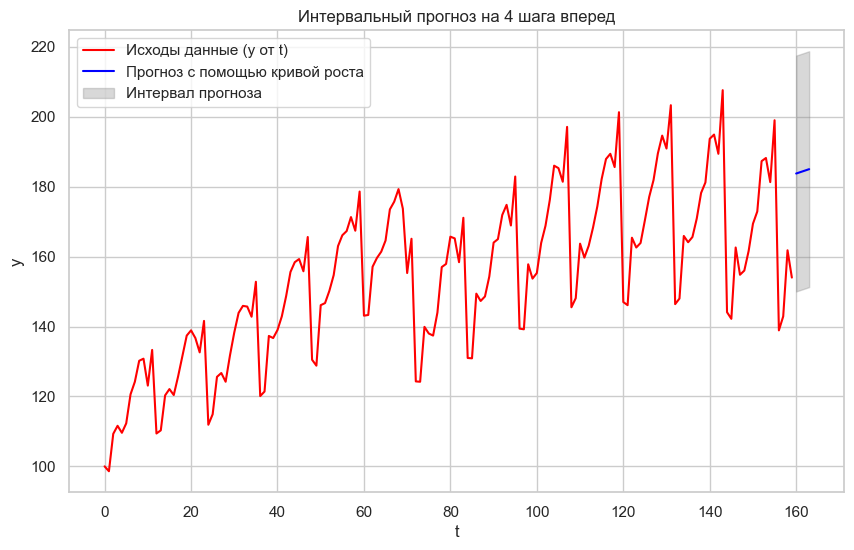

In [207]:
import numpy as np
import matplotlib.pyplot as plt

t_known = np.arange(0, 160, 1)  # Пример значений от 0 до 160 с шагом 1
y_known = df['BBR_EA_M_I'].values

# Строим график
plt.figure(figsize=(10, 6))

# График известных данных
plt.plot(t_known, y_known, label='Исходы данные (y от t)', color='red')

# График прогноза
plt.plot(future_t, future_y_point_forecast, label='Прогноз с помощью кривой роста', color='blue')

# Интервал прогноза
plt.fill_between(future_t, future_y_lower_bound, future_y_upper_bound, color='gray', alpha=0.3, label='Интервал прогноза')

# Настройки графика
plt.xlabel('t')
plt.ylabel('y')
plt.title('Интервальный прогноз на 4 шага вперед')
plt.legend()
plt.grid(True)
plt.show()


# 3. Осуществить прогнозирование с применением адаптивной модели прогнозирования Брауна.

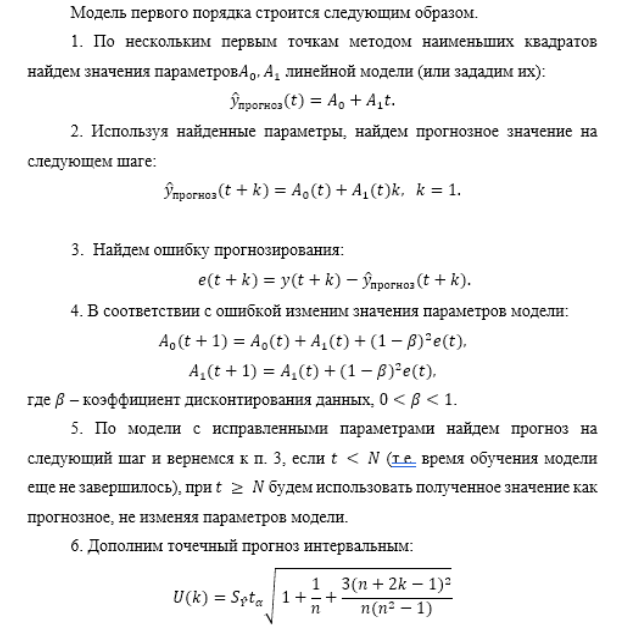

In [159]:
# Исходные данные (пример данных)
y = df['BBR_EA_M_I'].values
t = df['date'].values
t = np.arange(0, len(t), 1)

# выбираем нескольо первых точек данных для модели
t0 = t[:50]
y0 = y[:50]

X = sm.add_constant(t0)
linear_model = sm.OLS(y0, X)
linear_results = linear_model.fit()

# Инициализация начальных значений параметров
a0, a1 = linear_results.params
forecasts = []
beta = 0.89  # Коэффициент дисконтирования данных

for i in range(50, len(df)-1):
    # предсказание для следующего шага
    forecast = a0 + a1 * (t[i] + 1)
    forecasts.append(forecast)

    # ошибка прогнозирования
    error = y[i + 1] - forecast

    # корректировка параметров
    A0_new = a0 + a1 + (1 - beta)**2 * error
    A1_new = a1 + (1 - beta)**2 * error
    a0 = A0_new
    a1 = A1_new

print(a0, a1)

148.00729011481667 0.24561588928283162


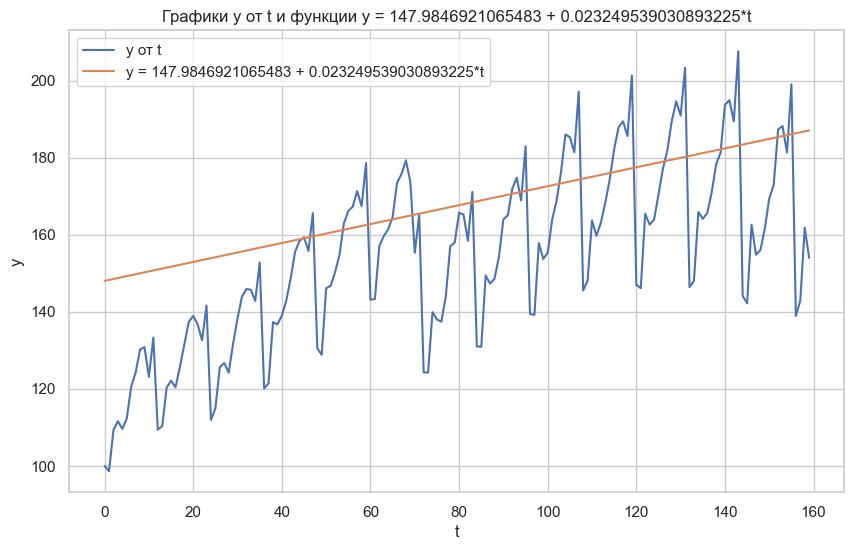

In [160]:
t = np.arange(0, len(df), 1)
y_func = a0 + a1*t
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='y от t')
plt.plot(t, y_func, label='y = 147.9846921065483 + 0.023249539030893225*t')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Графики y от t и функции y = 147.9846921065483 + 0.023249539030893225*t')
plt.legend()
plt.grid(True)
plt.show()

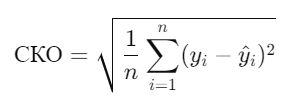

In [179]:
t = np.arange(0, len(df), 1)
y_pred = a0 + a1*t
S_y = np.sqrt(np.sum((y - y_pred)**2)/n)
S_y

21.875294907955787

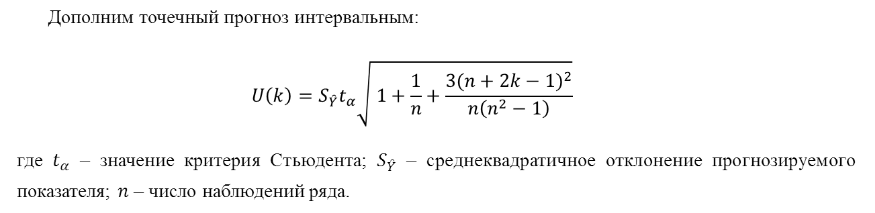

Посчитаем параметр u для интервального прогноза


In [182]:
from scipy.stats import t as t_test
n = len(y)
y = df['BBR_EA_M_I'].values
t = np.arange(0, len(df), 1)
y_pred = a0 + a1*t
S_y = np.sqrt(np.sum((y - y_pred)**2)/n)

t_test = t_test.ppf(0.95, n-2)
S_y = np.sqrt(np.sum((y - np.mean(y))**2) / (n-1))
u = S_y * t_test * np.sqrt(1 + 1/n + 3*(n+2*1-1)**2/(n*(n**2-1)))
u

39.310447355226785

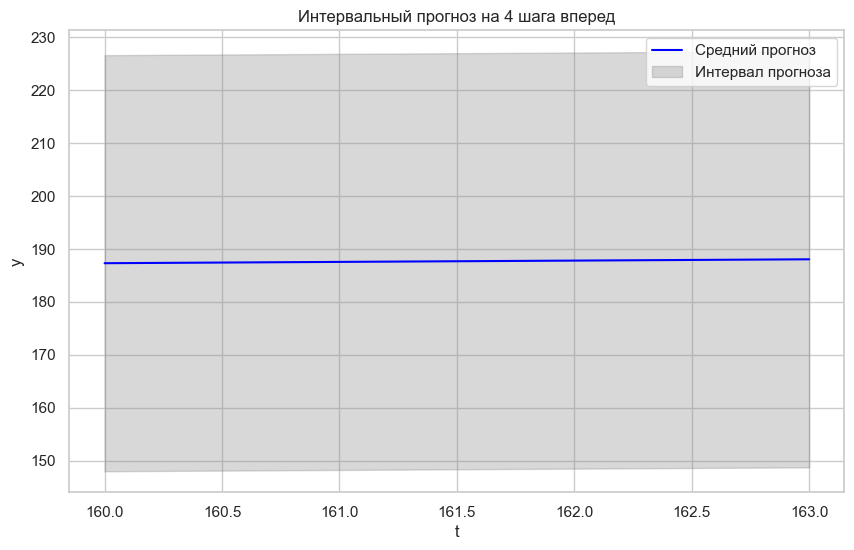

In [183]:
t_future = np.arange(n, n+4, 1)  # Пример значений от 100 до 103 (4 шага вперед) с шагом 1
y_future = a0 + a1 * t_future

# Создаем интервальный прогноз
y_lower = y_future - u  # Нижняя граница интервального прогноза
y_upper = y_future + u  # Верхняя граница интервального прогноза

# Строим график интервального прогноза
plt.figure(figsize=(10, 6))
plt.plot(t_future, y_future, label='Средний прогноз', color='blue')
plt.fill_between(t_future, y_lower, y_upper, color='gray', alpha=0.3, label='Интервал прогноза')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Интервальный прогноз на 4 шага вперед')
plt.legend()
plt.grid(True)
plt.show()


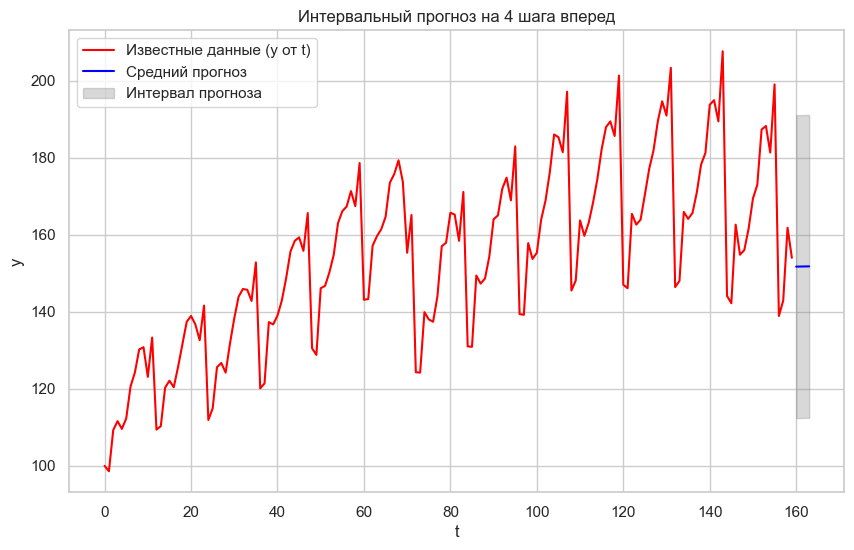

In [184]:
import numpy as np
import matplotlib.pyplot as plt

# Известные данные
t_known = np.arange(0, 160, 1)  # Пример значений от 0 до 160 с шагом 1
# y_known = 147.9846921065483 + 0.023249539030893225 * t_known  # Пример функции y = 147.9846921065483 + 0.023249539030893225*t

y_known = df['BBR_EA_M_I'].values

n = 160  # Начальное значение t для прогноза
t_future = np.arange(n, n + 4, 1)  # Пример значений от 160 до 163 (4 шага вперед) с шагом 1
y_future = 147.9846921065483 + 0.023249539030893225 * t_future

random_component = np.random.normal(0, 5, len(t_future))  # Пример: нормальный шум с средним 0 и стандартным отклонением 5

# Создаем интервальный прогноз
y_lower = y_future - u  # Нижняя граница интервального прогноза
y_upper = y_future + u  # Верхняя граница интервального прогноза

# Строим график
plt.figure(figsize=(10, 6))

# График известных данных
plt.plot(t_known, y_known, label='Известные данные (y от t)', color='red')

# График прогноза
plt.plot(t_future, y_future, label='Средний прогноз', color='blue')

# Интервал прогноза
plt.fill_between(t_future, y_lower, y_upper, color='gray', alpha=0.3, label='Интервал прогноза')

# Настройки графика
plt.xlabel('t')
plt.ylabel('y')
plt.title('Интервальный прогноз на 4 шага вперед')
plt.legend()
plt.grid(True)
plt.show()


# 4. Моделирование тренд-сезонных процессов. Применить Модель Хольта-Уинтерса 

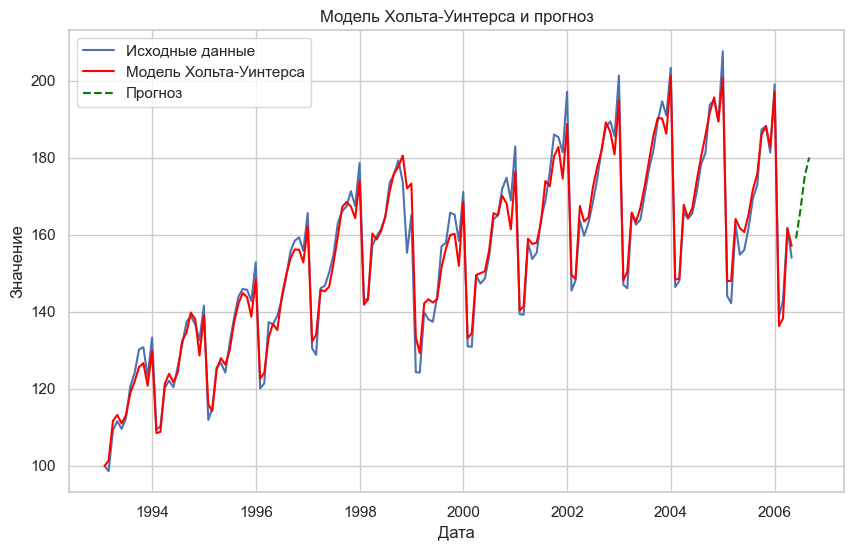

In [213]:
index = pd.date_range(start='1/1/1993', periods=len(y), freq='M')
ts = pd.Series(y, index=index)

hw_model = sm.tsa.ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12).fit()

forecast = hw_model.forecast(steps=4)

plt.figure(figsize=(10, 6))
plt.plot(ts, label='Исходные данные')
plt.plot(hw_model.fittedvalues, color='red', label='Модель Хольта-Уинтерса')
plt.plot(forecast, color='green', linestyle='--', label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Модель Хольта-Уинтерса и прогноз')
plt.legend()
plt.grid(True)
plt.show()

# Задание 5

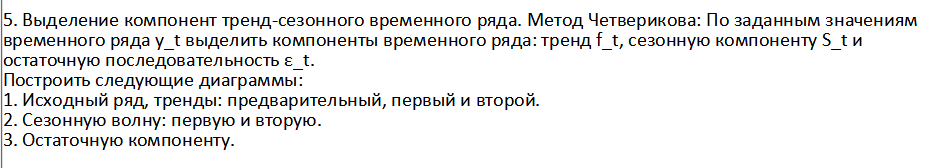

In [ ]:
y_t = df['BBR_EA_M_I'].values
t = df['date'].values
t = np.arange(0, n, 1)

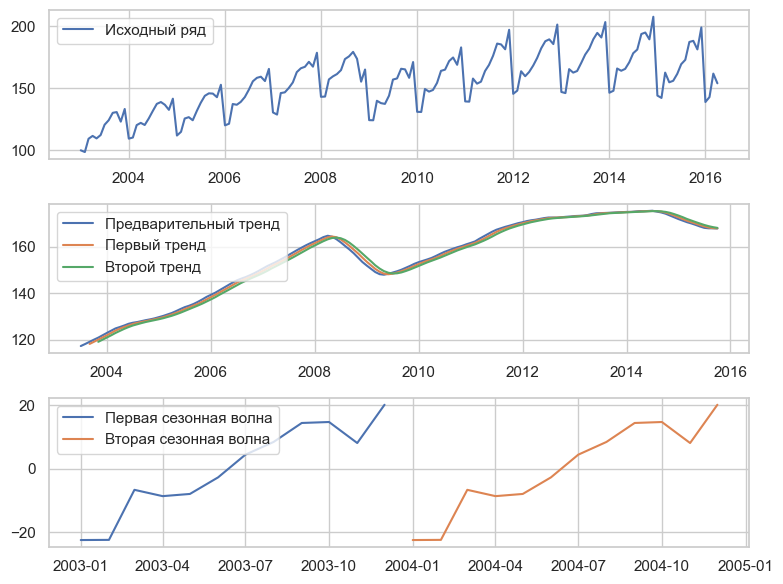

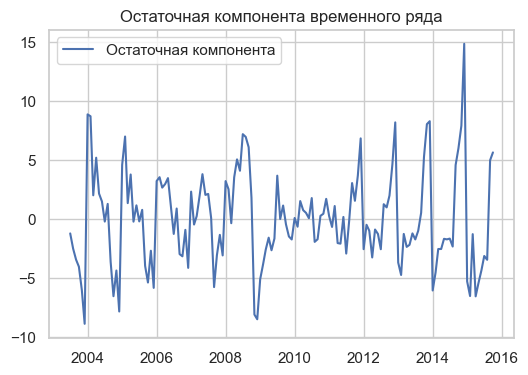

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Заданные значения временного ряда y_t (пример данных)
y_t = df['BBR_EA_M_I'].values  # Ваши данные временного ряда

# Создание временного индекса для данных
dates = pd.date_range(start='01-01-2022', periods=len(y_t), freq='M')
dates = df['date'].values

ts = pd.Series(y_t, index=dates)

# Выделение компонент методом Четверикова
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=12)  # Период сезонности указан как 12 месяцев (год)

# Построение диаграмм

# Исходный ряд и тренды
plt.figure(figsize=(8, 6))
plt.subplot(311)
plt.plot(ts, label='Исходный ряд')
plt.legend(loc='upper left')
plt.subplot(312)
plt.plot(decomposition.trend, label='Предварительный тренд')
plt.plot(decomposition.trend.rolling(window=3).mean(), label='Первый тренд')
plt.plot(decomposition.trend.rolling(window=5).mean(), label='Второй тренд')
plt.legend(loc='upper left')

# Сезонная волна
plt.subplot(313)
plt.plot(decomposition.seasonal[:12], label='Первая сезонная волна')
plt.plot(decomposition.seasonal[12:24], label='Вторая сезонная волна')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Остаточная компонента
plt.figure(figsize=(6, 4))
plt.plot(decomposition.resid, label='Остаточная компонента')
plt.legend(loc='upper left')
plt.title('Остаточная компонента временного ряда')
plt.show()
